# EMT Simulation of topology with slack, line and VSI

In [1]:
from villas.dataprocessing.readtools import *
from villas.dataprocessing.timeseries import *
import numpy as np
import matplotlib.pyplot as plt
import re
import dpsimpy

%matplotlib widget

In [ ]:
import os
import subprocess

#%matplotlib widget

name = 'EMT_Slack_PiLine_VSI_VoltageControlled_SteadyState_with_PF_Init'

dpsim_path = subprocess.Popen(['git', 'rev-parse', '--show-toplevel'], stdout=subprocess.PIPE).communicate()[0].rstrip().decode('utf-8')

path_exec = dpsim_path + '/build/dpsim/examples/cxx/'
sim = subprocess.Popen([path_exec + name], stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
print(sim.communicate()[0].decode())

In [3]:
modelName = 'EMT_Slack_PiLine_VSI_VoltageControlled_SteadyState_with_PF_Init_EMT'
path = 'logs/' + modelName + '/'
dpsim_result_file = path + modelName + '.csv'
PEAK1PH_TO_RMS3PH = np.sqrt(3.0/2.0)
ts_dpsim = read_timeseries_csv(dpsim_result_file)
ts_dpsim_simulink = read_timeseries_csv('logs/pcc_stationary_simulink.csv')
# ts_dpsim_v =  read_timeseries_csv('logs/voltage_pcc_simulink.csv')

column number: 13
results length: 5002
real column names: ['PLL_Phase_0', 'PLL_Phase_1', 'P_elec', 'Q_elec', 'Spannung_PCC_0', 'Spannung_PCC_1', 'Spannung_PCC_2', 'Spannung_Quelle_0', 'Spannung_Quelle_1', 'Spannung_Quelle_2', 'Strom_RLC_0', 'Strom_RLC_1', 'Strom_RLC_2']
complex column names: []
column number: 8
results length: 2555
real column names: ['Spannung_PCC_0', 'Spannung_PCC_1', 'Spannung_PCC_2', 'Current_PCC_0', 'Current_PCC_1', 'Current_PCC_2', 'Wirkleistung_PCC', 'Blindleistung_PCC']
complex column names: []


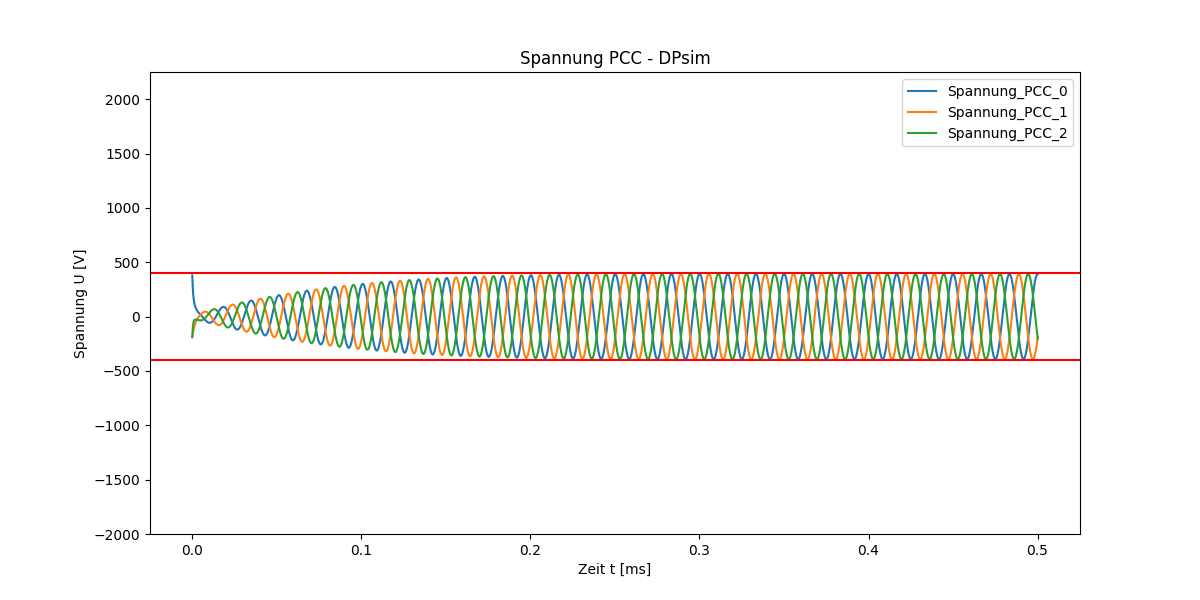

In [4]:
plt.figure(figsize=(12,6))
plt.title('Spannung PCC - DPsim')
plt.xlabel('Zeit t [ms]')
plt.ylabel('Spannung U [V]')
for ts_name, ts_obj  in ts_dpsim.items():
    if ts_name in ['Spannung_PCC_0', 'Spannung_PCC_1', 'Spannung_PCC_2']:
        plt.plot(ts_obj.time, PEAK1PH_TO_RMS3PH*ts_obj.values, label=ts_name)
plt.axhline(y =400, color = 'r', linestyle = '-')
plt.axhline(y =-400, color = 'r', linestyle = '-')
plt.ylim(-2000,2250)
plt.legend()
plt.show()

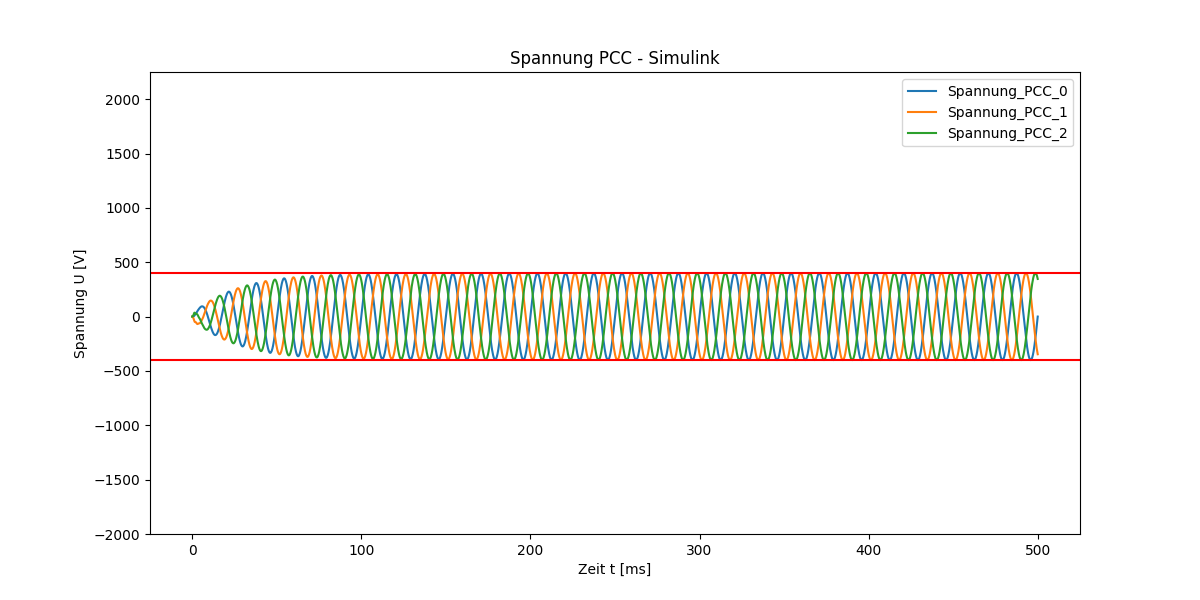

In [5]:
plt.figure(figsize=(12,6))
plt.title('Spannung PCC - Simulink')
plt.xlabel('Zeit t [ms]')
plt.ylabel('Spannung U [V]')
for ts_name, ts_obj  in ts_dpsim_simulink.items():
    if ts_name in ['Spannung_PCC_0', 'Spannung_PCC_1', 'Spannung_PCC_2']:
        plt.plot(1000*ts_obj.time, ts_obj.values, label=ts_name)
plt.axhline(y =400, color = 'r', linestyle = '-')
plt.axhline(y =-400, color = 'r', linestyle = '-')
plt.ylim(-2000,2250)
plt.legend()
plt.show()

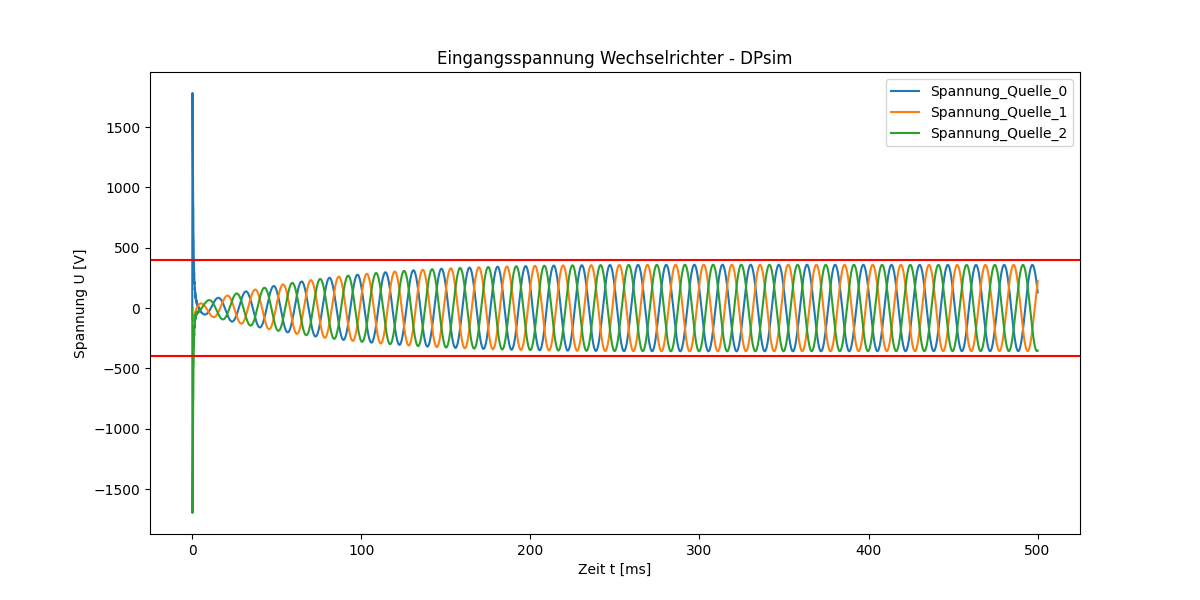

In [6]:
plt.figure(figsize=(12,6))
plt.title('Eingangsspannung Wechselrichter - DPsim')
plt.xlabel('Zeit t [ms]')
plt.ylabel('Spannung U [V]')
for ts_name, ts_obj  in ts_dpsim.items():
    if ts_name in ['Spannung_Quelle_0','Spannung_Quelle_1','Spannung_Quelle_2']:
        plt.plot(1000*ts_obj.time, ts_obj.values, label=ts_name)
plt.axhline(y =400, color = 'r', linestyle = '-')
plt.axhline(y =-400, color = 'r', linestyle = '-')
plt.legend()
plt.show()

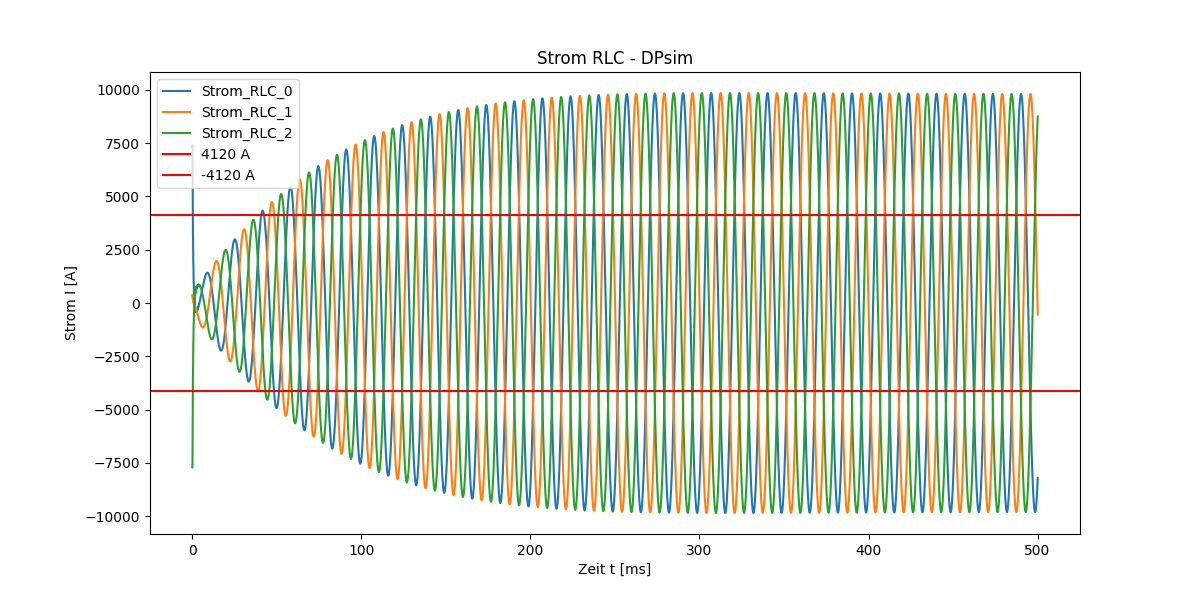

In [7]:
plt.figure(figsize=(12,6))
plt.title('Strom RLC - DPsim')
plt.xlabel('Zeit t [ms]')
plt.ylabel('Strom I [A]')
for ts_name, ts_obj  in ts_dpsim.items():
    if ts_name in ['Strom_RLC_0','Strom_RLC_1','Strom_RLC_2']:
        plt.plot(1000*ts_obj.time, ts_obj.values, label=ts_name)
plt.axhline(y =4120, color = 'r', linestyle = '-',label='4120 A')
plt.axhline(y =-4120, color = 'r', linestyle = '-',label='-4120 A')
plt.legend()
plt.show()

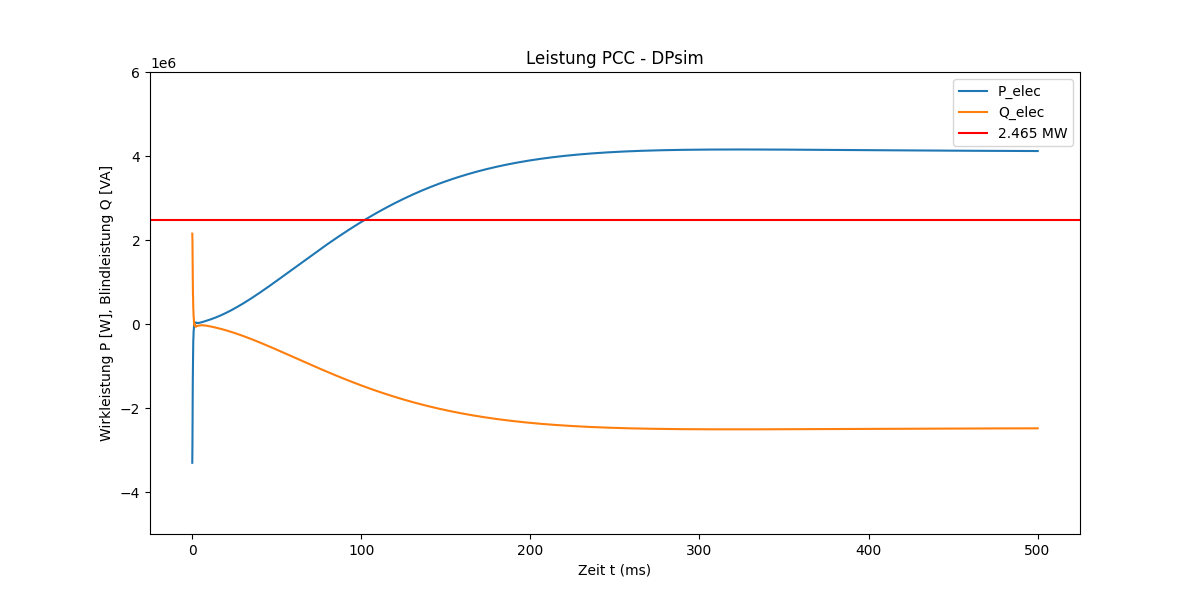

In [8]:
plt.figure(figsize=(12,6))
plt.title('Leistung PCC - DPsim')
plt.xlabel('Zeit t (ms)')
plt.ylabel('Wirkleistung P [W], Blindleistung Q [VA]')
for ts_name, ts_obj  in ts_dpsim.items():
    if ts_name in ['P_elec','Q_elec']:
        plt.plot(1000*ts_obj.time, ts_obj.values, label=ts_name)
plt.axhline(y =2465000, color = 'r', linestyle = '-', label='2.465 MW')
plt.ylim(-5e6, 6e6)
plt.legend()
plt.show()


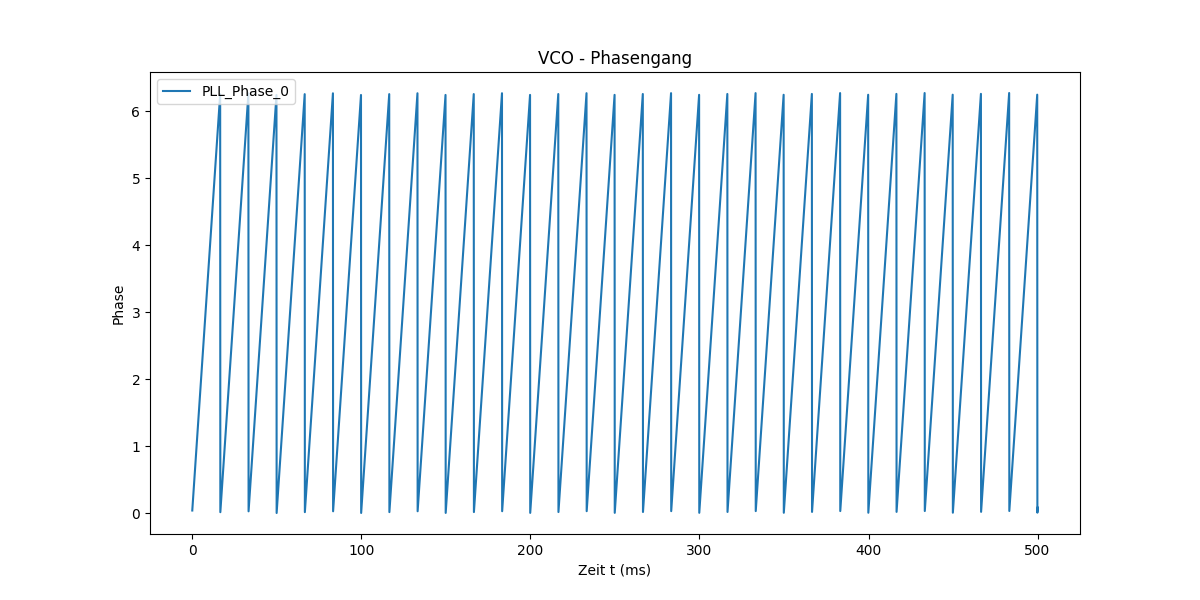

In [10]:
plt.figure(figsize=(12,6))
plt.title('VCO - Phasengang')
plt.xlabel('Zeit t (ms)')
plt.ylabel('Phase')
for ts_name, ts_obj  in ts_dpsim.items():
    if ts_name in ['PLL_Phase_0']:
        plt.plot(1000*ts_obj.time, ts_obj.values % 6.283, label=ts_name)
plt.legend()
plt.show()